In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
from collections import defaultdict

from federate import federated_train
from utils import compute_metrics


import torch

from datasets import Dataset
from transformers import AutoTokenizer, Trainer, AutoModelForSequenceClassification, TrainingArguments
print(torch.__version__)
print(torch.cuda.is_available())


2.6.0+cpu
False


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
# MODEL_PATH = "mBERT" # I have donloaded distilled mBERT (hugggingface not available in China)
MODEL_PATH = "distilbert-base-multilingual-cased"
DATA_DIR = "data"
seed = 42

In [4]:
portion = 0.1
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv")).sample(frac=portion, random_state=seed)
val_df = pd.read_csv(os.path.join(DATA_DIR, "validation.csv")).sample(frac=portion, random_state=seed)
test_df = pd.read_csv(os.path.join(DATA_DIR, "test.csv")).sample(frac=portion, random_state=seed)
languages = list(train_df.language.unique())

In [5]:
def plot_df_language_distribution(df: pd.DataFrame, all_languages: list[str], title="Language Distribution"):
    all_languages_sorted = sorted(all_languages)
    df['language'] = pd.Categorical(df['language'], categories=all_languages_sorted, ordered=True)
    
    counts_series = df['language'].value_counts(dropna=False)
    full_counts_series = counts_series.reindex(all_languages_sorted, fill_value=0)

    language_counts = full_counts_series.reset_index()
    language_counts.columns = ['language', 'count']

    language_counts['language'] = pd.Categorical(
        language_counts['language'],
        categories=all_languages_sorted,
        ordered=True
    )
    language_counts = language_counts.sort_values('language')


    plt.figure(figsize=(8, 4))
    sns.barplot(data=language_counts, x='language', y='count', hue='language', palette='viridis', legend=False)

    for i, row in enumerate(language_counts.itertuples()):
        plt.text(i, row.count, str(row.count), ha='center', va='bottom', fontsize=9)

    plt.title(title, fontsize=14)
    plt.xlabel("Language", fontsize=12)
    plt.ylabel("Samples", fontsize=12)
    plt.xticks(ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

def plot_language_distribution(dataframes: list[pd.DataFrame], all_languages: list[str]):
    for client_id, client_df in enumerate(dataframes):
        plot_df_language_distribution(client_df, all_languages, "Client: " + str(client_id + 1))

In [6]:
def get_indexes_per_language(df: pd.DataFrame):
    lang_to_indices = defaultdict(list)
    for lang, group in df.groupby('language'):
        lang_to_indices[lang].extend(group.index.tolist())
    return lang_to_indices

def uniform_split(df: pd.DataFrame, lang_to_indices, num_clients=4):
    client_indices = [[] for _ in range(num_clients)]

    for label, indices in lang_to_indices.items():
        np.random.shuffle(indices)
        split_sizes = [len(indices) // num_clients] * num_clients
        for i in range(len(indices) % num_clients):
            split_sizes[i] += 1

        start = 0
        for client_id, size in enumerate(split_sizes):
            end = start + size
            client_indices[client_id].extend(indices[start:end])
            start = end

    datasets = [df.loc[sorted(indices)] for indices in client_indices]
    return datasets

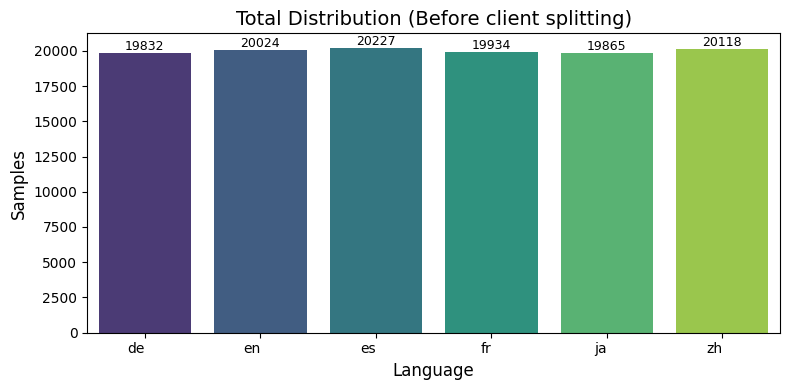

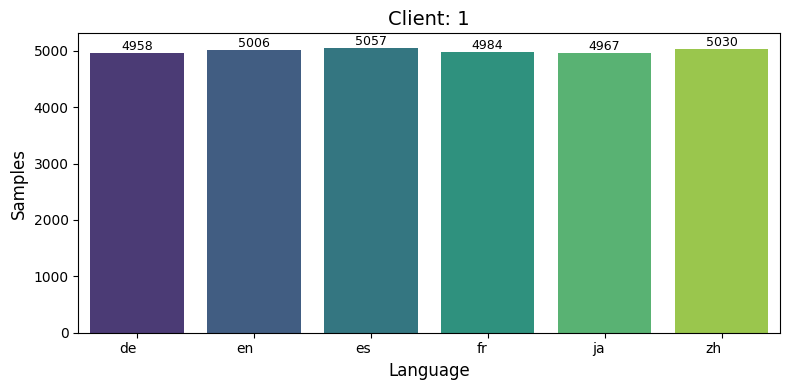

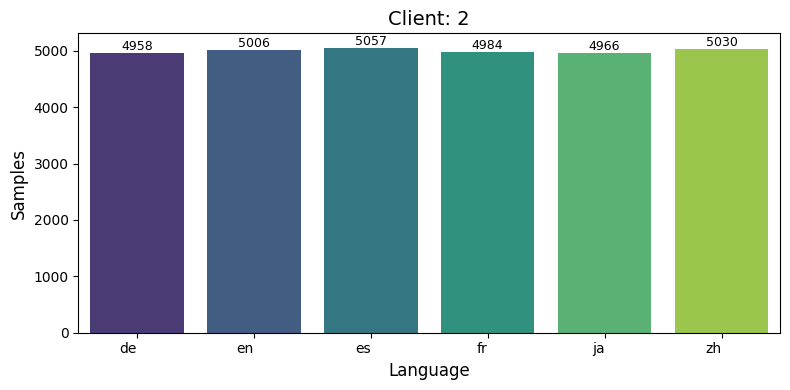

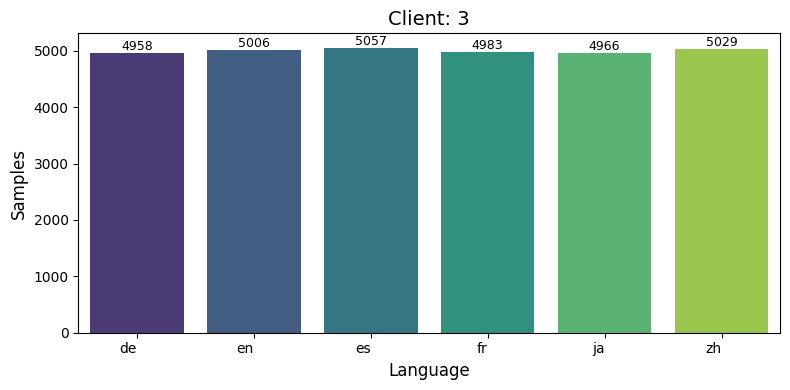

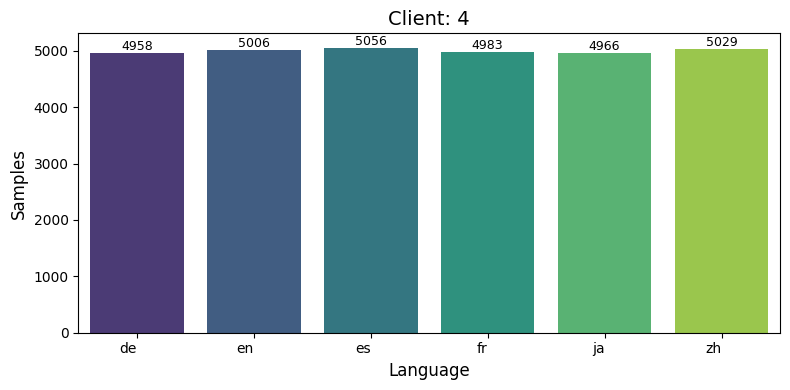

In [7]:
lang_to_indices = get_indexes_per_language(train_df)
plot_df_language_distribution(train_df, languages, "Total Distribution (Before client splitting)")
plot_language_distribution(uniform_split(train_df, lang_to_indices.copy()), languages)

In [8]:
def dirichlet_split(df: pd.DataFrame, lang_to_indices, beta: float, num_clients: int = 4, seed: int = None):
    rng = np.random.default_rng(seed)
    client_selected_indices = [[] for _ in range(num_clients)]

    for label, indices in lang_to_indices.items():
        shuffled_label_indices = rng.permutation(indices)
        proportions = rng.dirichlet([beta] * num_clients)
        proportions = (proportions * len(indices)).astype(int)

        diff = len(indices) - np.sum(proportions)
        for i in range(diff):
            proportions[i % num_clients] += 1

        current_idx_pos = 0
        for client_id, count in enumerate(proportions):
            selected_for_client = shuffled_label_indices[current_idx_pos : current_idx_pos + count]
            client_selected_indices[client_id].extend(selected_for_client)
            current_idx_pos += count

    datasets = [df.loc[sorted(idx_list)] for idx_list in client_selected_indices]
    return datasets

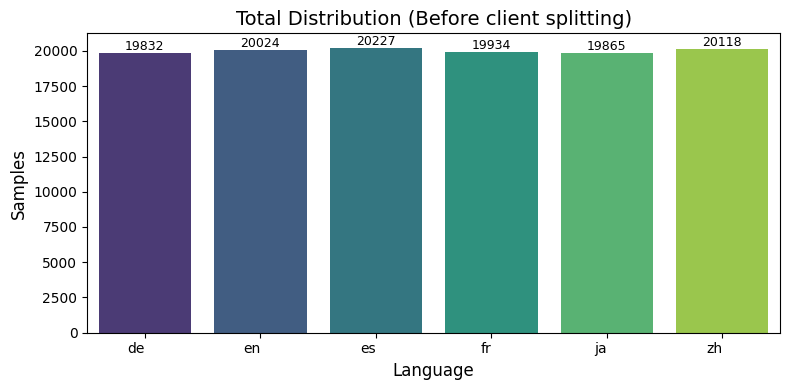

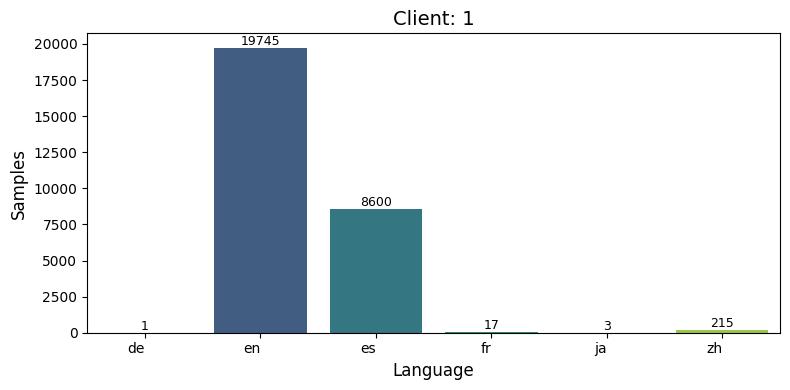

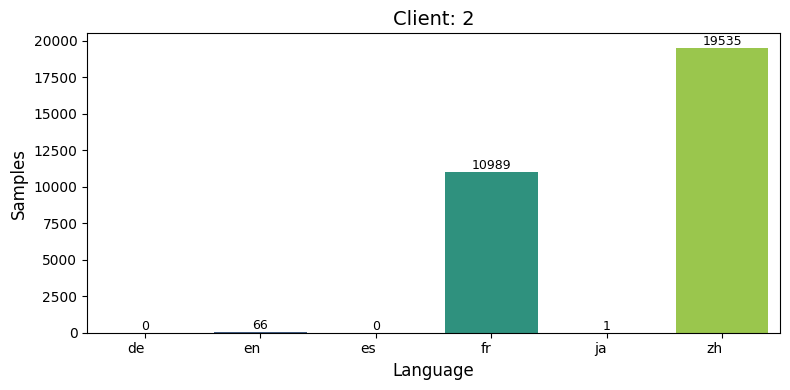

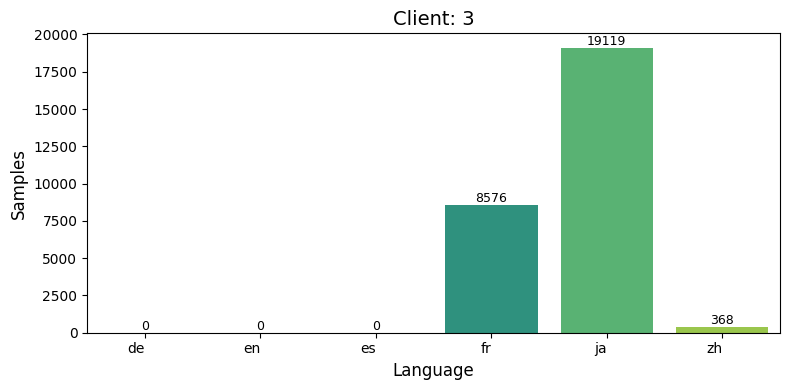

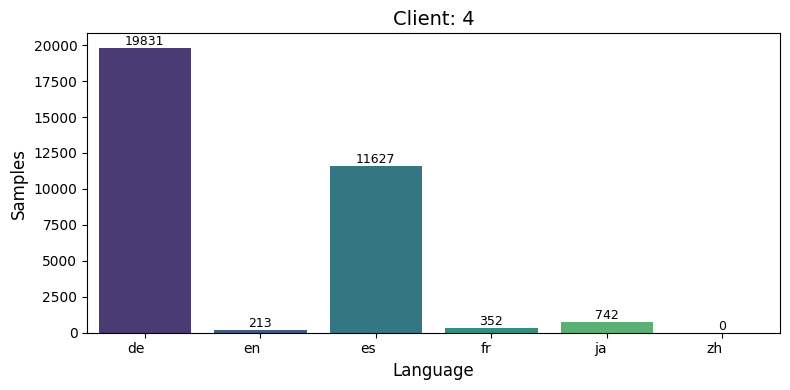

In [9]:
client_dfs = dirichlet_split(train_df, lang_to_indices, beta=0.1, seed=seed)
plot_df_language_distribution(train_df, languages, "Total Distribution (Before client splitting)")
plot_language_distribution(client_dfs, languages)

In [10]:
from datasets import Dataset

def label(df):
    # Map stars to 0/1/2
    def map_sentiment(stars):
        if stars <= 2:
            return 0  # negative
        elif stars == 3:
            return 1  # neutral
        else:
            return 2  # positive
    df["label"] = df["stars"].apply(map_sentiment)
    return Dataset.from_pandas(df[["review_body", "label"]])

train_ds = label(train_df)
val_ds = label(val_df)
test_ds = label(test_df)


In [11]:

# ==== Tokenizer ====
print("Loading tokenizer from local path...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

def tokenize(example):
    return tokenizer(example["review_body"], truncation=True, padding="max_length",max_length=512)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

columns_to_keep = ["input_ids", "attention_mask", "label"]
train_ds.set_format(type="torch", columns=columns_to_keep)
val_ds.set_format(type="torch", columns=columns_to_keep)
test_ds.set_format(type="torch", columns=columns_to_keep)


Loading tokenizer from local path...


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [12]:
# n = len(train_ds)
# subset_size = n // 4
# client_datasets = [
#     train_ds.select(range(0, subset_size)),
#     train_ds.select(range(subset_size, 2 * subset_size)),
#     train_ds.select(range(2 * subset_size, 3 * subset_size)),
#     train_ds.select(range(3 * subset_size, 4 * subset_size)),
# ]

# print(train_ds)
# for client in client_datasets:
#     print(client)

client_datasets = []
for client in client_dfs:
    curr = label(client).map(tokenize, batched=True)
    curr.set_format(type="torch", columns=columns_to_keep)
    client_datasets.append(curr)
    print(curr)

Map:   0%|          | 0/28581 [00:00<?, ? examples/s]

Dataset({
    features: ['review_body', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 28581
})


Map:   0%|          | 0/30591 [00:00<?, ? examples/s]

Dataset({
    features: ['review_body', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 30591
})


Map:   0%|          | 0/28063 [00:00<?, ? examples/s]

Dataset({
    features: ['review_body', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 28063
})


Map:   0%|          | 0/32765 [00:00<?, ? examples/s]

Dataset({
    features: ['review_body', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 32765
})


In [13]:

NUM_LABELS = 3

# ==== Load Model ====
print("Loading model from local path...")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=NUM_LABELS)

# ==== Metrics ====


BATCH_SIZE = 32
EPOCHS = 3




Loading model from local path...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from utils import compute_discrepancy_aware_weights
from enum import Enum

class FedAlgo(Enum):
    FedAvg = 1
    FedDisco = 2

def get_client_weights(client_datasets: list[Dataset], fed_algo: FedAlgo, 
                       language_counts: list[list[int]] = None, **kwargs):
    if fed_algo == FedAlgo.FedAvg:
        total_size = sum(len(dataset) for dataset in client_datasets)
        assert total_size > 0
        return [len(dataset) / total_size for dataset in client_datasets]
    elif fed_algo == FedAlgo.FedDisco:
        raise NotImplementedError("FedDisco not implemented yet")
        # num_classes = kwargs.get('num_classes')
        # a = kwargs.get('a', 1.0)
        # b = kwargs.get('b', 0.0)
        # metric = kwargs.get('metric', 'l2')
        # 
        # if num_classes is None:
        #     raise ValueError("num_classes must be provided for FedDisco.")
        # 
        # return compute_discrepancy_aware_weights(
        #     client_language_distribution_counts=client_language_distribution_counts,
        #     num_classes=num_classes,
        #     a=a,
        #     b=b,
        #     metric=metric
        # )
        # compute_discrepancy_aware_weights()

In [14]:
federated_train(
    base_model=model,
    client_datasets=client_datasets,
    val_ds=val_ds,
    test_ds=test_ds,
    client_weights=get_client_weights(client_datasets, FedAlgo.FedAvg),
    local_epochs=2,
    global_rounds=3,
    batch_size=BATCH_SIZE,
    learning_rate=5e-5,
    device=device
)


--- Global Round 1/3 ---
 Evaluating global model before client updates...


KeyboardInterrupt: 